In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
# removes warnings
import warnings
warnings.filterwarnings('ignore')

#suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.2f}'.format

In [3]:
cars_au=pd.read_csv('cars_ac.csv')
cars_au.shape

(5525, 8)

In [4]:
cars_au.tail()

,Name,Price,Location,Model_Year,Mileage,Fuel_Type,Gearbox,Gearbox2
5520,VW Golf Variant 1.6 Multifuel Euro 4,33000kr,"nyköping, Södermanland",2009,17871 mil,1.6L Ethanol (E85),Manual,102 HP (75 kW)
5521,VW Golf VII 1.4TSI 140hk GT M&K-Värm Kamera Dr...,95000kr,"Uppsala, Uppsala",1 / 4,Jun 2013,16 387 mil,1.4L Petrol,Manual
5522,"Mercedes EQC400 4MATIC AMG Premium Plus//3,95%...",479000kr,"42536 Hisingskärra, Västra Götaland",2021,3610 mil,Electric,≈ 411 km,Automatic
5523,Nissan Qashqai +2 Qashqai+2 2.0 4x4 CVT 7-Sits...,79900kr,"Rosersberg, Stockholm",Oct 2011,18347 mil,2.0L Petrol,Automatic,142 HP (104 kW)
5524,"Volvo V40 T5 Geartronic Carbon Edition, R Desi...",199990kr,"Kungälv, Västra Götaland",2016,11930 mil,2.0L Petrol,Automatic,245 HP (180 kW)


In [5]:
def fix_gear(row):
    if 'km' in str(row['Gearbox']):
        row['Gearbox'] = row['Gearbox2']
        row['Gearbox2'] = None
    return row

# Define a function to fix rows where Model_Year consists of '/'
def fix_row(row):
    if '/' in str(row['Model_Year']):
        row['Model_Year'] = row['Mileage']  # Assign 'Mileage' to 'Model_Year'
        row['Mileage'] = row['Fuel_Type']  # Assign 'Fuel_Type' to 'Mileage'
        row['Fuel_Type'] = row['Gearbox']  # Assign 'Gearbox' to 'Fuel_Type'
        row['Gearbox'] = row['Gearbox2']  # Assign 'Gearbox2' to 'Gearbox'
        row['Gearbox2'] = None  # Clear 'Gearbox2' as it is no longer needed
    return row


def correct_data_types(df):
    df['Price'] = df['Price'].replace('kr', '', regex=True).astype(int)
    df['Mileage'] = df['Mileage'].astype(str).str.replace(r'\D', '', regex=True)
    df['Mileage'] = df['Mileage'].replace('', np.nan).astype(float).astype('Int64')
    df['Year'] = df['Model_Year'].str.extract(r'(\b\d{4}\b)').astype(float)  # Extract year as float
    df = df.dropna(subset=['Year'])  # Drop rows where Year is NaN
    df['Year'] = df['Year'].astype(int)  # Convert remaining years to int
    return df

def clean_data(df):
    df = df.apply(fix_gear, axis=1)
    df = df[df['Gearbox'].isin(['Manual', 'Automatic'])]
    df = df.drop('Gearbox2', axis=1)
    df = df[df['Mileage'] != 'Electric'].reset_index(drop=True)
    df = correct_data_types(df)
    df.rename(columns={'Gearbox': 'Transmission'}, inplace=True)
    df = df.apply(fix_row, axis=1)
    return df

cars_au = clean_data(cars_au)

In [7]:
cars_au.shape

(4036, 8)

##### Feature Engineering

In [9]:
# Feature Engineering

def feature_engineering(df):
    # Create a Price_per_Mile feature
    df['Price_per_Mile'] = df['Price'] / df['Mileage']
    
    # Extract the brand name from the Name column
    df['Brand'] = df['Name'].str.split(' ').str[0]
    
    # Extract the model name from the Name column
    df['Brand_Model'] = df['Name'].str.split().str[:2].str.join(' ')
    
    
    # Categorize the Fuel_Type column
    def categorize_fuel_type(fuel_type):
        if 'Electric' in fuel_type and '/' not in fuel_type:
            return 'Electric'
        elif 'Hybrid' in fuel_type or 'Electric/' in fuel_type:
            return 'Hybrid'
        elif 'Petrol' in fuel_type and 'Electric/' not in fuel_type:
            return 'Petrol'
        elif 'Diesel' in fuel_type and 'Electric/' not in fuel_type:
            return 'Diesel'
        elif 'Natural gas' in fuel_type:
            return 'Natural Gas'
        else:
            return 'Ethanol'
    
    # Apply the categorization to the Fuel_Type column
    df['Fuel'] = df['Fuel_Type'].apply(categorize_fuel_type)
    
    # Extract the county from the Location column
    def extract_city(location):
        if 'Delivered to you' in location:
            return None  # Mark rows with 'Delivered to you' for deletion
        elif ',' in location:
            return location.split(',')[1].strip()  # Extract county after comma
        else:
            return location.strip()  # If no comma, return the full location as county
    
    df['County'] = df['Location'].apply(extract_city)
    
    # Drop rows where County is None
    df = df.dropna(subset=['County'])
    
    return df

# Apply feature engineering
cars_au = feature_engineering(cars_au)

In [10]:
cars_au.tail()

,Name,Price,Location,Model_Year,Mileage,Fuel_Type,Transmission,Year,Price_per_Mile,Brand,Brand_Model,Fuel,County
4034,VW Golf 1.6 Multifuel,62000,"kalmar, Kalmar",2009,8845,1.6L Ethanol (E85),Manual,2009,7.01,VW,VW Golf,Ethanol,Kalmar
4035,VW Golf Variant 1.6 Multifuel Euro 4,33000,"nyköping, Södermanland",2009,17871,1.6L Ethanol (E85),Manual,2009,1.85,VW,VW Golf,Ethanol,Södermanland
4036,"Mercedes EQC400 4MATIC AMG Premium Plus//3,95%...",479000,"42536 Hisingskärra, Västra Götaland",2021,3610,Electric,Automatic,2021,132.69,Mercedes,Mercedes EQC400,Electric,Västra Götaland
4037,Nissan Qashqai +2 Qashqai+2 2.0 4x4 CVT 7-Sits...,79900,"Rosersberg, Stockholm",Oct 2011,18347,2.0L Petrol,Automatic,2011,4.35,Nissan,Nissan Qashqai,Petrol,Stockholm
4038,"Volvo V40 T5 Geartronic Carbon Edition, R Desi...",199990,"Kungälv, Västra Götaland",2016,11930,2.0L Petrol,Automatic,2016,16.76,Volvo,Volvo V40,Petrol,Västra Götaland


In [12]:
cars_au.County.value_counts()

County
Stockholm             1160
Västra Götaland        580
Skåne                  541
Dalarna                261
Halland                178
Örebro                 160
Södermanland           152
Västmanland            150
Jämtland               132
Kalmar                 129
Gotland                123
gävle                  123
Uppsala                 87
Jönköping               79
Östergötland            49
Kronoberg               25
Blekinge                20
Värmland                17
Västernorrland          12
Gävleborg                8
Västerbotten             8
Norrbotten               6
89160 Örnsköldsvik       1
uddevalla                1
vara                     1
Motala                   1
Name: count, dtype: int64

Retain only the observations in the County column where the count of occurrences is more than 5.

In [13]:
# Remove counties with 1 or 2 observations in the dataset.
county_counts = cars_au['County'].value_counts()
counties_to_keep = county_counts[county_counts > 5].index

# Keep only rows where the County column is in the list of counties to keep
cars_au = cars_au[cars_au['County'].isin(counties_to_keep)]
cars_au.shape

(4000, 13)

In [14]:
cars_au=cars_au.reset_index(drop=True)

## 4.Exploratory Data Analysis (EDA)

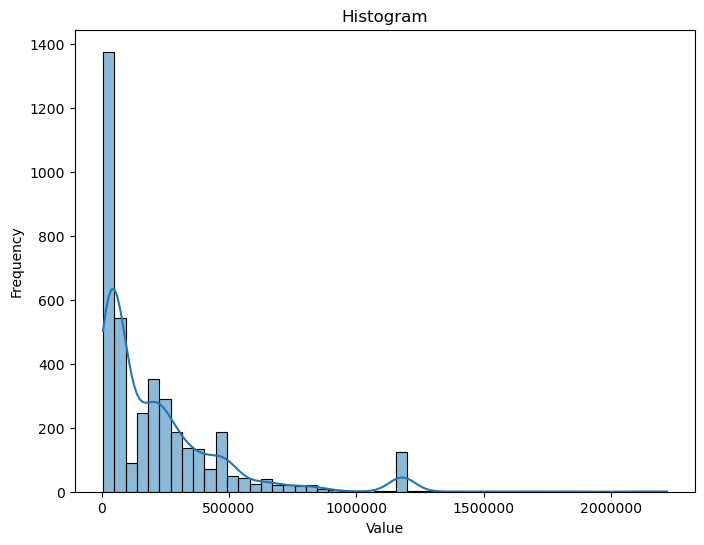

In [16]:
plt.figure(figsize=(8, 6))
sns.histplot(cars_au['Price'], bins=50, kde=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.ticklabel_format(style='plain')
plt.show()

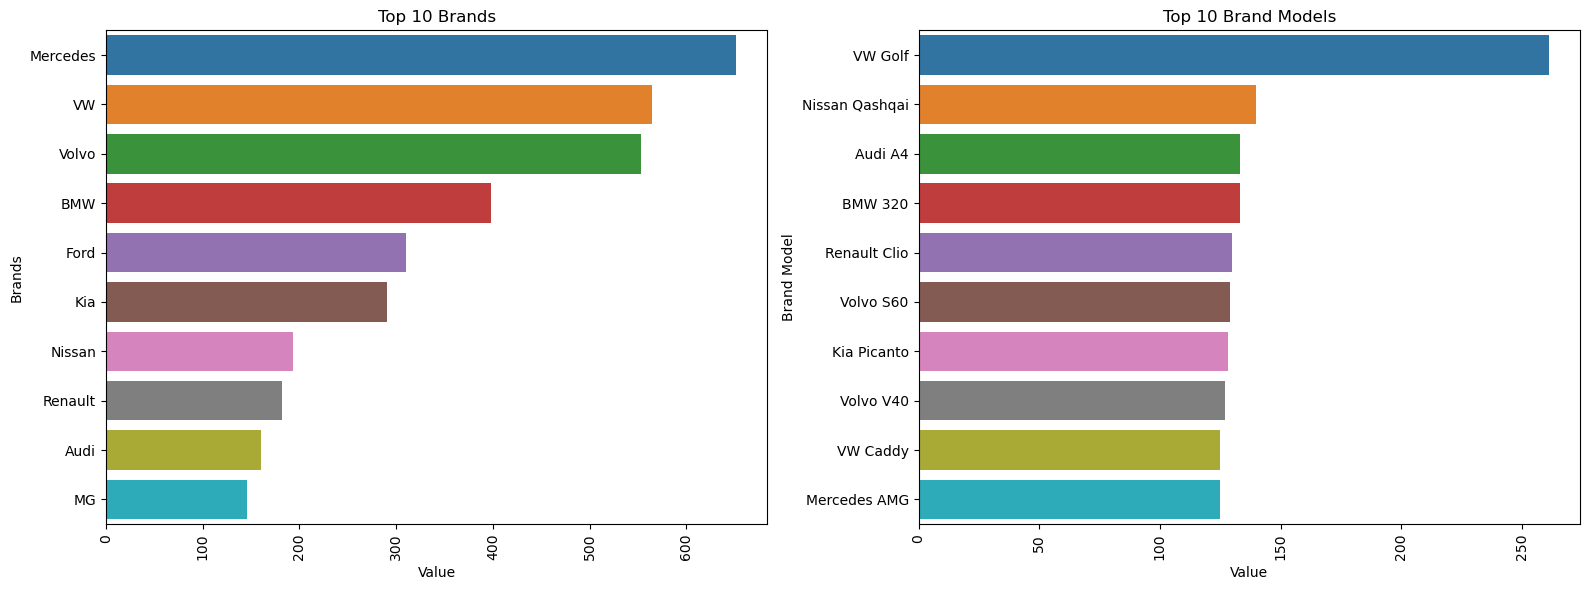

In [17]:

# Data for Brand
var_brand = cars_au['Brand']
var_brand_value_counts = var_brand.value_counts().head(10)

# Data for Brand Model
var_brand_model = cars_au['Brand_Model']
var_brand_model_value_counts = var_brand_model.value_counts().head(10)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for Brand
sns.barplot(ax=axes[0], x=var_brand_value_counts, y=var_brand_value_counts.index)
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Brands')
axes[0].set_title('Top 10 Brands')
axes[0].tick_params(axis='x', rotation=90)

# Plot for Brand Model
sns.barplot(ax=axes[1], x=var_brand_model_value_counts, y=var_brand_model_value_counts.index)
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Brand Model')
axes[1].set_title('Top 10 Brand Models')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

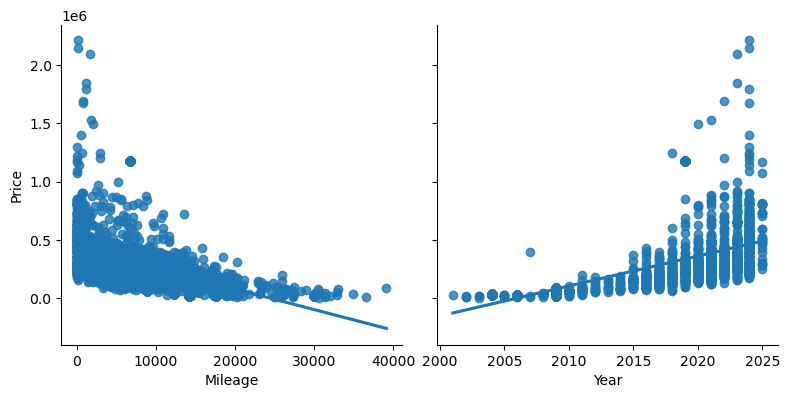

In [18]:
# Create the pairplot
sns.pairplot(cars_au, 
             x_vars=['Mileage', 'Year'],
             y_vars='Price',
             diag_kind='auto',
             kind='reg',
             height=4)

# Show the plot
plt.show()

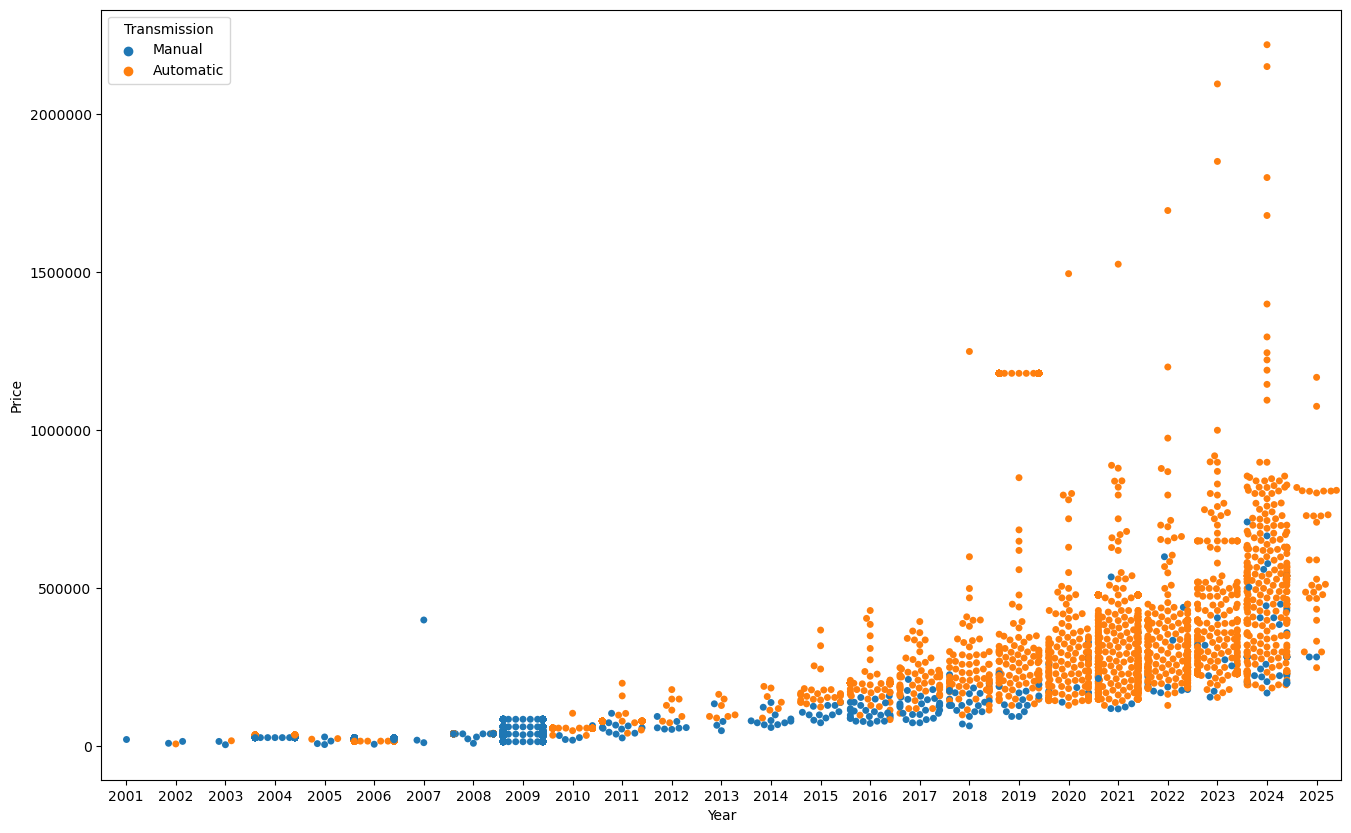

In [19]:
plt.figure(figsize = (16,10))
plt.ticklabel_format(style='plain')
sns.swarmplot(x = 'Year',y = 'Price',data = cars_au,hue='Transmission')
plt.show()

In [23]:
cars_au[cars_au['Year']==2009]['Transmission'].value_counts()

Transmission
Manual    735
Name: count, dtype: int64

In [34]:
cars_au.groupby('Fuel')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Fuel,,,,,,,,
Diesel,954.00,124949.58,133055.04,9999.00,39900.00,48900.00,176250.00,879000.00
Electric,690.00,368551.35,187287.69,89800.00,209900.00,349900.00,479000.00,1295000.00
Ethanol,254.00,57059.45,52085.85,33000.00,33000.00,62000.00,62000.00,399900.00
Hybrid,423.00,400587.63,217472.25,129800.00,259900.00,339900.00,459900.00,2149900.00
Natural Gas,124.00,62015.32,40685.33,58000.00,58000.00,58000.00,58000.00,509000.00
Petrol,1555.00,203729.61,333637.58,5500.00,27000.00,79900.00,199990.00,2219000.00


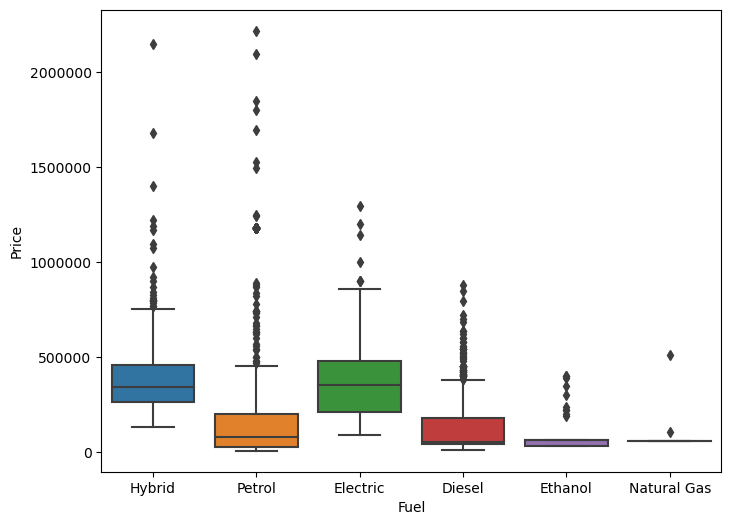

In [36]:
plt.figure(figsize=(8,6))
plt.ticklabel_format(style='plain')
sns.boxplot(x='Fuel',y='Price',data=cars_au)
plt.show()

### Price of Used Cars in Different Counties

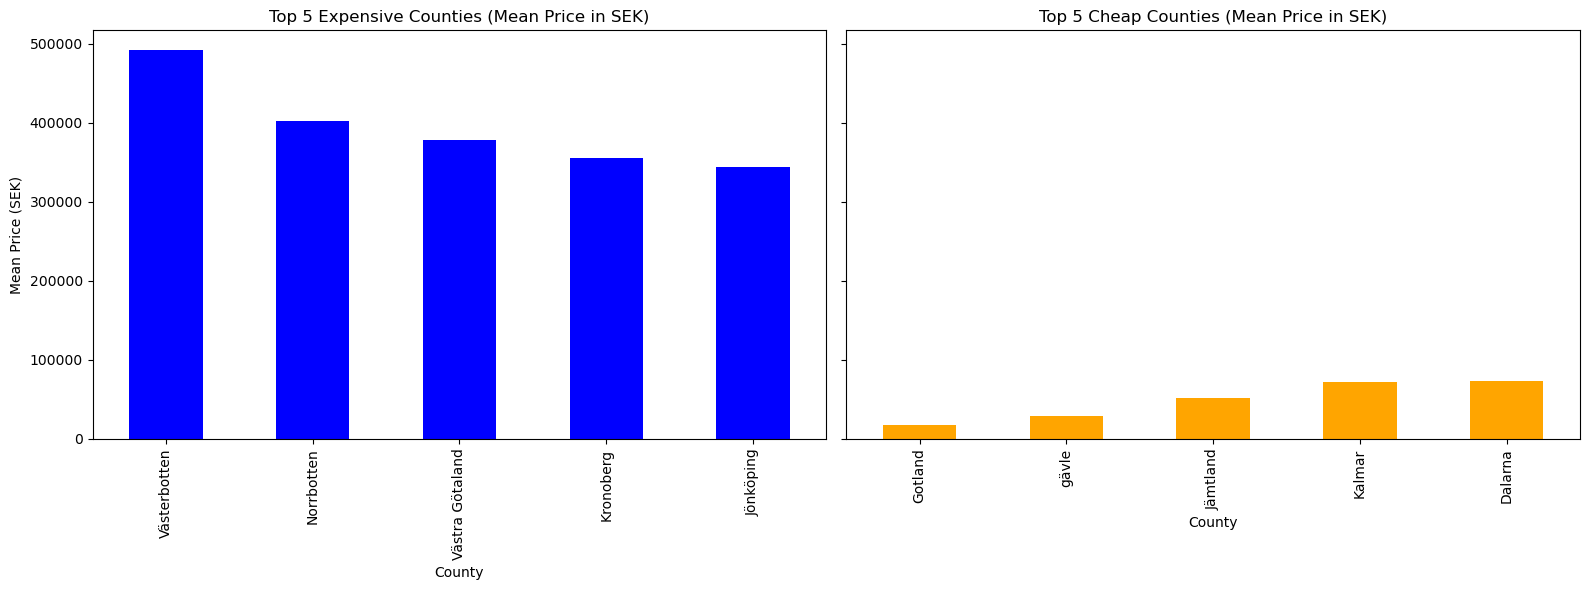

In [37]:
# Calculate the mean prices for expensive and cheap counties
expensive_counties = cars_au.groupby(['County'])['Price'].mean().sort_values(ascending=False).head()
cheap_counties = cars_au.groupby(['County'])['Price'].mean().sort_values().head()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the expensive counties
expensive_counties.plot(
    ax=axes[0],
    kind='bar',
    color='blue',
    title='Top 5 Expensive Counties (Mean Price in SEK)'
)
axes[0].set_ylabel('Mean Price (SEK)')

# Plot the cheap counties
cheap_counties.plot(
    ax=axes[1],
    kind='bar',
    color='orange',
    title='Top 5 Cheap Counties (Mean Price in SEK)'
)

plt.tight_layout()
plt.show()


### Price Vs. Brands

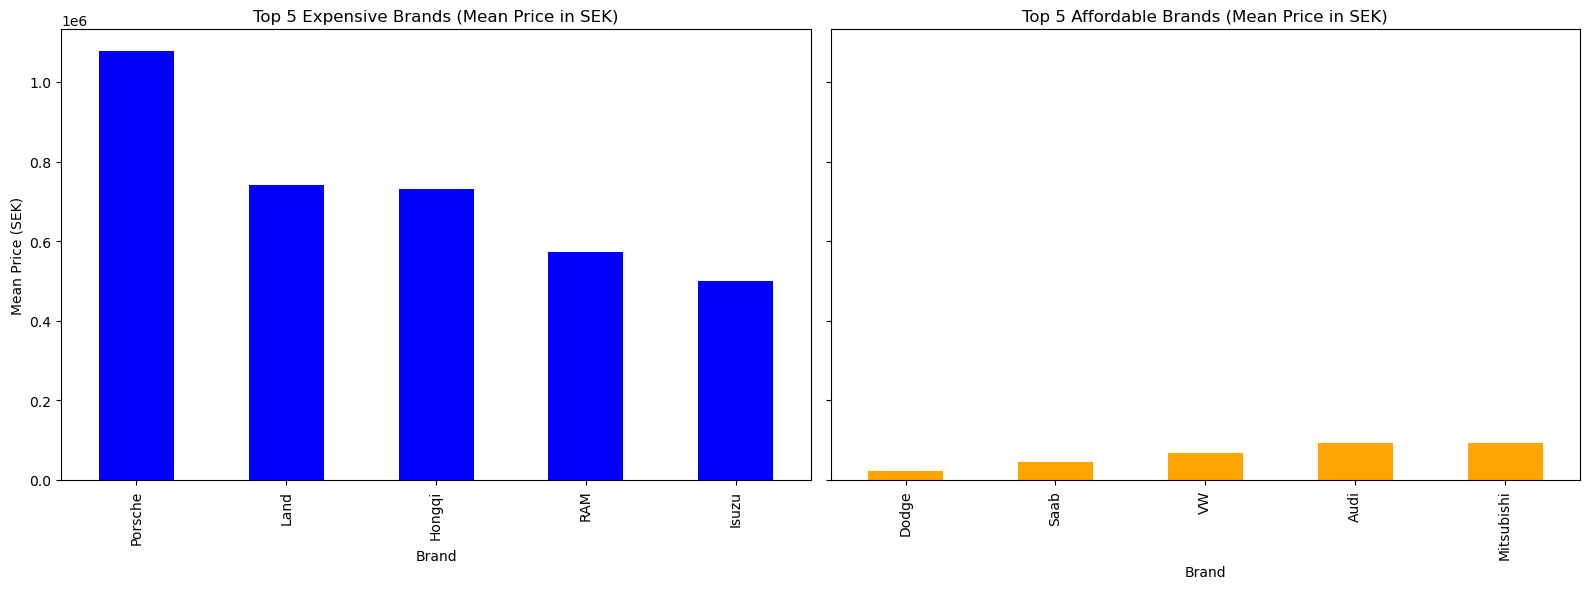

In [38]:
# Calculate the mean prices for expensive and cheap car brands
steep_brand = cars_au.groupby(['Brand'])['Price'].mean().sort_values(ascending=False).head()
affordable_brand = cars_au.groupby(['Brand'])['Price'].mean().sort_values().head()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the expensive brands
steep_brand.plot(
    ax=axes[0],
    kind='bar',
    color='blue',
    title='Top 5 Expensive Brands (Mean Price in SEK)'
)
axes[0].set_ylabel('Mean Price (SEK)')

# Plot the affordable brands
affordable_brand.plot(
    ax=axes[1],
    kind='bar',
    color='orange',
    title='Top 5 Affordable Brands (Mean Price in SEK)'
)

plt.tight_layout()
plt.show()

In [41]:
cars_au.to_csv('cars_au_to_ml.csv')

In [40]:
# Feature Engineering
df = cars_au[['Brand', 'Mileage', 'Fuel', 'Transmission', 'Year', 'County', 'Price_per_Mile', 'Price']]

# One-Hot Encoding for categorical variables
dummies = pd.get_dummies(df[['Brand', 'Fuel', 'Transmission', 'County']], drop_first=True, dtype='int')
df = df.drop(['Brand', 'Fuel', 'Transmission', 'County'], axis=1)
df = pd.concat([df, dummies], axis=1)

# Define feature matrix X and target variable y
X = df.drop('Price', axis=1)
y = df['Price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Standardize the feature matrix
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert back to DataFrame for better readability
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=101),
    "Decision Tree": DecisionTreeRegressor(random_state=101),
    "Support Vector Regressor": SVR()
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "R2 Score": r2}

# Display the results
print("\nModel Performance:")
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE = {metrics['RMSE']:.2f}, R2 Score = {metrics['R2 Score']:.2f}")

# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("\nPerforming Grid Search for Random Forest...")
grid_search = GridSearchCV(RandomForestRegressor(random_state=101), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate the optimized Random Forest model
y_pred_best_model = best_model.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_model)
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_model)

print("\nOptimized Random Forest Performance:")
print(f"RMSE = {rmse_best_rf:.2f}, R2 Score = {r2_best_rf:.2f}")

Training Linear Regression...
Training Random Forest...
Training Decision Tree...
Training Support Vector Regressor...

Model Performance:
Linear Regression: RMSE = 128640.81, R2 Score = 0.76
Random Forest: RMSE = 48255.56, R2 Score = 0.97
Decision Tree: RMSE = 108396.93, R2 Score = 0.83
Support Vector Regressor: RMSE = 272956.81, R2 Score = -0.10

Performing Grid Search for Random Forest...
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Optimized Random Forest Performance:
RMSE = 46009.29, R2 Score = 0.97


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('cars_au_to_ml.csv')

# Select relevant columns
columns = ['Brand', 'Mileage', 'Fuel', 'Transmission', 'Year', 'County', 'Price_per_Mile', 'Price']
df = df[columns]

# Check for missing values
print(df.isnull().sum())

# Fill missing values if any
df = df.dropna()

# Separate features and target
X = df.drop('Price', axis=1)
y = df['Price']

# Categorical columns
categorical_cols = ['Brand', 'Fuel', 'Transmission', 'County']

# Numeric columns
numeric_cols = ['Mileage', 'Year', 'Price_per_Mile']

# Preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)

# Save the scaler
import joblib
scaler_filename = "scaler.pkl"
joblib.dump(preprocessor, scaler_filename)

Brand             0
Mileage           0
Fuel              0
Transmission      0
Year              0
County            0
Price_per_Mile    0
Price             0
dtype: int64


['scaler.pkl']

In [43]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} MSE: {mse}")



Linear Regression MSE: 15154835598.131868
Decision Tree MSE: 5477542229.35625
Random Forest MSE: 3100274462.9662185
SVR MSE: 64134123697.76301


In [44]:
from sklearn.model_selection import GridSearchCV

# Choose the best model from the previous step, suppose it's Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Save the best model
model_filename = "best_model.pkl"
joblib.dump(best_model, model_filename)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   9.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END m

['best_model.pkl']

In [45]:
# Evaluate the optimized best model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Optimized Best Model MSE: {mse}")

Optimized Best Model MSE: 1959349976.448378


In [48]:
predictions=best_model.predict(X_test)

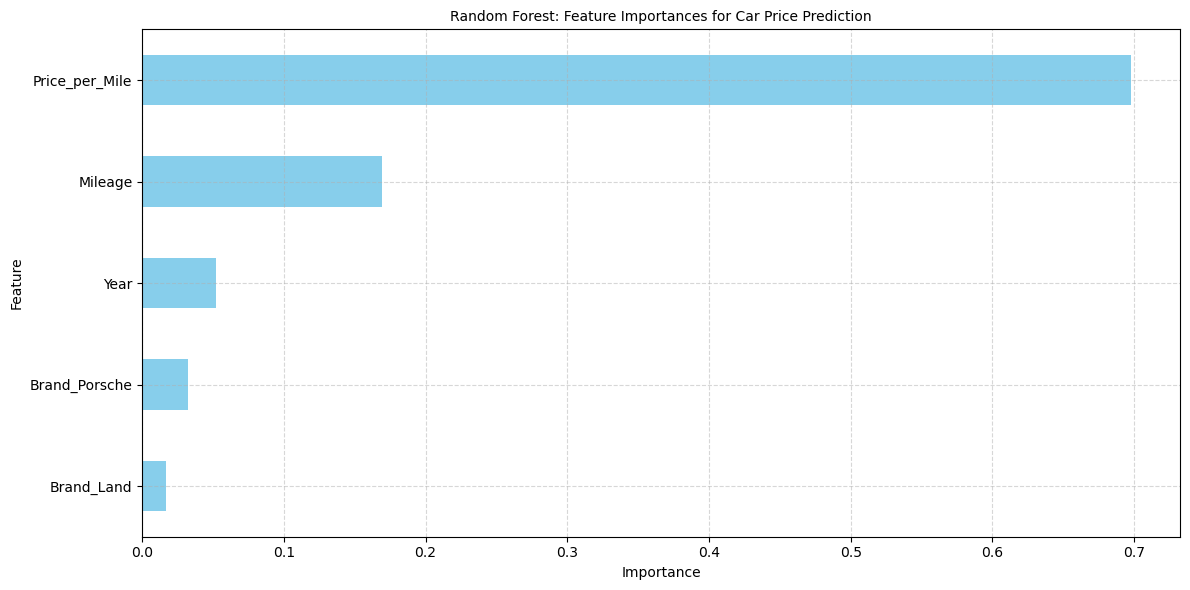

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming best_model and preprocessor are already defined and trained

# Extract feature names
# The ColumnTransformer stores the names in a different structure, so we need to get them
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_features = numeric_cols + list(cat_features)

# Create a Pandas Series to store feature importances from the model
feature_rank = pd.Series(best_model.feature_importances_, index=all_features, name='Importance').sort_values(ascending=True, inplace=False)[-5:]

# Plotting a horizontal bar chart to visualize feature importances
ax = feature_rank.plot(kind='barh', figsize=(12, 6), color='skyblue')

# Setting x-axis and y-axis labels, and the title for the plot 
plt.xlabel("Importance", fontsize=10)
plt.ylabel("Feature", fontsize=10)
plt.title("Random Forest: Feature Importances for Car Price Prediction", fontsize=10)

# Add line grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [56]:

#import pandas as pd

# Assuming `predictions` is the array of predicted prices from your best model
# and `cars_df` is the original DataFrame loaded earlier

# Create a DataFrame with actual, predicted, and price difference
undervalued_df = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),
    'Predictions': predictions
})

# Calculate the price difference
undervalued_df['Price_Difference'] = undervalued_df['Predictions'] - undervalued_df['Actual']

# Identify undervalued cars with a threshold of 10%, select those cars with a price difference that is higher than 10% of the car's true price.
threshold = 0.1
undervalued_mask = undervalued_df['Price_Difference'] > (threshold * undervalued_df['Actual'])

# Filter undervalued cars
undervalued_df = undervalued_df[undervalued_mask]

# Extract the indices of the filtered undervalued cars
filtered_indices = undervalued_df.index

# Extract the original details from the cars_df using the filtered indices
original_details = df.loc[filtered_indices, ['Brand', 'Fuel', 'Transmission', 'Mileage', 'Year', 'County']]

# Combine undervalued DataFrame with original details
undervalued_with_details = undervalued_df.join(original_details.reset_index(drop=True))

# Display the first few rows of the detailed DataFrame
undervalued_with_details.tail()

,Actual,Predictions,Price_Difference,Brand,Fuel,Transmission,Mileage,Year,County
731,779900,1294324.28,514424.28,NaN,NaN,NaN,NaN,NaN,NaN
733,1145000,1436470.60,291470.60,NaN,NaN,NaN,NaN,NaN,NaN
757,239900,310955.16,71055.16,NaN,NaN,NaN,NaN,NaN,NaN
775,30000,34333.86,4333.86,NaN,NaN,NaN,NaN,NaN,NaN
798,147000,163149.52,16149.52,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
len(undervalued_with_details)

54

In [57]:
import pandas as pd

# Assuming `predictions` is the array of predicted prices from your best model
# and `df` is the original DataFrame loaded earlier

# Create a DataFrame with actual, predicted, and price difference
undervalued_df = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),
    'Predictions': predictions
})

# Calculate the price difference
undervalued_df['Price_Difference'] = undervalued_df['Predictions'] - undervalued_df['Actual']

# Identify undervalued cars with a threshold of 10%, select those cars with a price difference that is higher than 10% of the car's true price.
threshold = 0.1
undervalued_mask = undervalued_df['Price_Difference'] > (threshold * undervalued_df['Actual'])

# Filter undervalued cars
undervalued_df = undervalued_df[undervalued_mask]

# Extract the indices of the filtered undervalued cars
filtered_indices = undervalued_df.index

# Extract the original details from the df using the filtered indices
# Ensure we use the correct column names
original_details = df.loc[filtered_indices, ['Brand', 'Fuel', 'Transmission', 'Mileage', 'Year', 'County']]

# Combine undervalued DataFrame with original details
undervalued_with_details = undervalued_df.join(original_details.reset_index(drop=True))

# Handle missing values (e.g., fill with a placeholder or drop rows)
# Here we fill NaNs with a placeholder, but you can choose to drop them or use another method
undervalued_with_details.fillna('Missing', inplace=True)

# Display the first few rows of the detailed DataFrame
print(undervalued_with_details.head())

    Actual  Predictions  Price_Difference    Brand      Fuel Transmission  \
12  282070    470756.51         188686.51     Ford  Electric    Automatic   
50  239920    269377.35          29457.35       MG  Electric    Automatic   
52  239900    360331.44         120431.44       MG  Electric    Automatic   
70  239900    283595.43          43695.43  Missing   Missing      Missing   
98  144000    161582.24          17582.24  Missing   Missing      Missing   

    Mileage     Year     County  
12  1706.00  2022.00  Stockholm  
50  4734.00  2021.00      Skåne  
52  4763.00  2021.00  Stockholm  
70  Missing  Missing    Missing  
98  Missing  Missing    Missing  


To-do

-update notebook
-upload app.py
-sql mode
-sql udemy

In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

# Load the dataset
df = pd.read_csv('cars_au_to_ml.csv')

# Select relevant columns
columns = ['Brand', 'Brand_Model', 'Mileage', 'Fuel', 'Transmission', 'Year', 'County', 'Price']
df = df[columns]

# Check for missing values
print(df.isnull().sum())

# Fill missing values if any
df = df.dropna()

# Separate features and target
X = df.drop('Price', axis=1)
y = df['Price']

# Categorical columns
categorical_cols = ['Brand', 'Brand_Model', 'Fuel', 'Transmission', 'County']

# Numeric columns
numeric_cols = ['Mileage', 'Year']

# Preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)

# Save the scaler
scaler_filename = "scaler.pkl"
joblib.dump(preprocessor, scaler_filename)

Brand           0
Brand_Model     0
Mileage         0
Fuel            0
Transmission    0
Year            0
County          0
Price           0
dtype: int64


['scaler.pkl']

In [71]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=101)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    

    

    print(f"{name} RMSE: {rmse}.2f")



Linear Regression RMSE: 52557.513375455936.2f
Decision Tree RMSE: 92091.0184001947.2f
Random Forest RMSE: 51487.75861169865.2f
SVR RMSE: 272806.53653011343.2f


In [72]:
# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("\nPerforming Grid Search for Random Forest...")
grid_search = GridSearchCV(RandomForestRegressor(random_state=101), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
rf = grid_search.best_estimator_
rf.fit(X_train, y_train)

# Evaluate the optimized Random Forest model
y_pred_best_rf = rf.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("\nOptimized Random Forest Performance:")
print(f"RMSE = {rmse_best_rf:.2f}, R2 Score = {r2_best_rf:.2f}")


Performing Grid Search for Random Forest...
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Optimized Random Forest Performance:
RMSE = 52068.67, R2 Score = 0.96


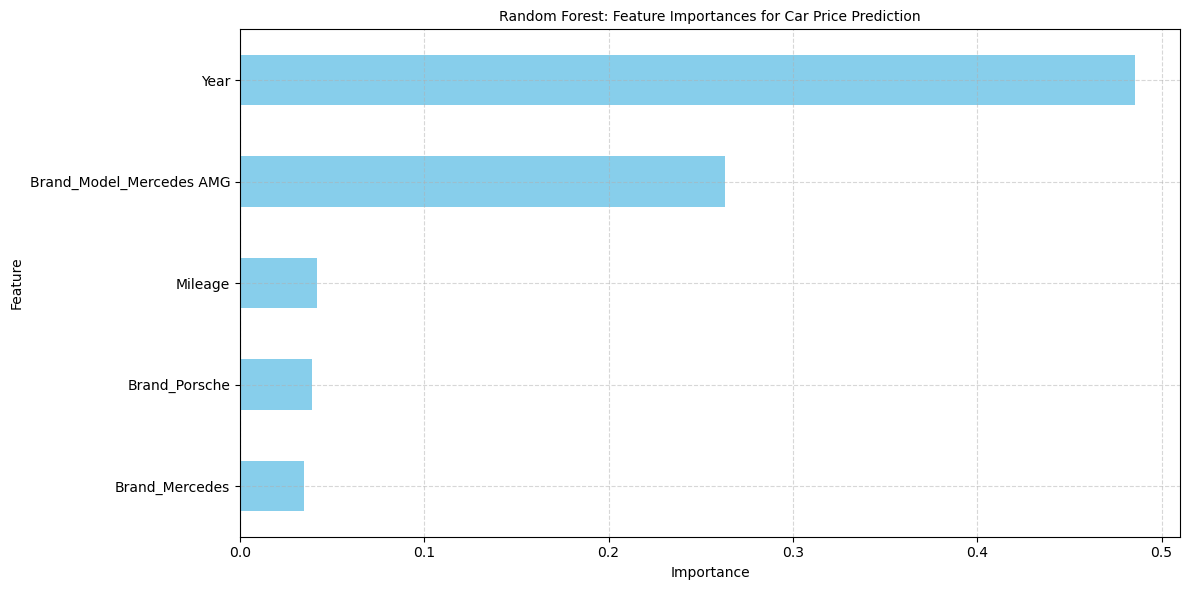

In [74]:
# The ColumnTransformer stores the names in a different structure, so we need to get them
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_features = numeric_cols + list(cat_features)

# Create a Pandas Series to store feature importances from the model
feature_rank = pd.Series(rf.feature_importances_, index=all_features, name='Importance').sort_values(ascending=True, inplace=False)[-5:]

# Plotting a horizontal bar chart to visualize feature importances
ax = feature_rank.plot(kind='barh', figsize=(12, 6), color='skyblue')

# Setting x-axis and y-axis labels, and the title for the plot 
plt.xlabel("Importance", fontsize=10)
plt.ylabel("Feature", fontsize=10)
plt.title("Random Forest: Feature Importances for Car Price Prediction", fontsize=10)

# Add line grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [76]:
#save model
import joblib

joblib.dump(rf, 'rf_model.pkl')

['rf_model.pkl']

In [77]:
# Load the saved model
import joblib
loaded_model = joblib.load('rf_model.pkl')

In [78]:
# Predict prices using the test set
predictions=loaded_model.predict(X_test)

In [93]:

undervalued_df = pd.DataFrame({
    'Actual': y_test,
    'Predictions': predictions
})

# Calculate the price difference
undervalued_df['Price_Difference'] = undervalued_df['Predictions'] - undervalued_df['Actual']

# Identify undervalued cars with a threshold of 10%, select those cars with a price difference that is higher than 10% of the car's true price.
threshold = 0.1
undervalued_mask = undervalued_df['Price_Difference'] > (threshold * undervalued_df['Actual'])

# Filter undervalued cars
undervalued_df = undervalued_df[undervalued_mask]

# Extract the indices of the filtered undervalued cars
filtered_indices = undervalued_df.index

# Extract the original details from the df using the filtered indices
# Ensure we use the correct column names
original_details = df.loc[filtered_indices, ['Brand','Fuel', 'Transmission', 'Mileage', 'Year', 'County']]

# Combine undervalued DataFrame with original details
undervalued_with_details = undervalued_df.join(original_details.reset_index(drop=True))

# Display the first few rows of the detailed DataFrame
undervalued_with_details.tail()

,Actual,Predictions,Price_Difference,Brand,Fuel,Transmission,Mileage,Year,County
1610,183900,254796.00,70896.00,NaN,NaN,NaN,NaN,NaN,NaN
1705,79900,122598.00,42698.00,NaN,NaN,NaN,NaN,NaN,NaN
909,229900,300685.00,70785.00,NaN,NaN,NaN,NaN,NaN,NaN
136,179900,203508.00,23608.00,NaN,NaN,NaN,NaN,NaN,NaN
328,234500,275914.88,41414.88,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
undervalued_with_details.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 821 to 328
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Actual            91 non-null     int64  
 1   Predictions       91 non-null     float64
 2   Price_Difference  91 non-null     float64
 3   Brand             2 non-null      object 
 4   Fuel              2 non-null      object 
 5   Transmission      2 non-null      object 
 6   Mileage           2 non-null      float64
 7   Year              2 non-null      float64
 8   County            2 non-null      object 
dtypes: float64(4), int64(1), object(4)
memory usage: 9.2+ KB


In [94]:
print("Undervalued DataFrame shape:", undervalued_df.shape)
print("Original DataFrame shape:", df.shape)
print("Filtered Indices:", filtered_indices)
print("Original Details Shape:", original_details.shape)


Undervalued DataFrame shape: (91, 3)
Original DataFrame shape: (4000, 8)
Filtered Indices: Index([ 821,  792,  589, 1632, 1505, 1763, 1250, 1434, 1381, 1260, 1656, 1333,
        141, 1413,  919, 1481, 1645, 1500, 1725,  996, 1707, 1059, 1020,  314,
         59, 1254, 1571,  479, 1303, 1493,  959,  498, 1043, 1483,  312, 1430,
        366, 1295,  164,  292,  945, 1192,  137, 1111, 1029,  935, 1686, 1713,
       1596,  669, 1358, 1772,  768, 1353, 1703,  215,  203, 1398, 1242, 1233,
        330,  429,  844,  420, 1170,    4,  316,  325, 1447,  323,  148, 1328,
        747,  621, 1236,  129, 1359, 1541, 1700, 1628, 1597, 1270,  926,  372,
        563, 1253, 1610, 1705,  909,  136,  328],
      dtype='int64')
Original Details Shape: (91, 6)


In [96]:
print("Undervalued Mask:", undervalued_mask)
print("Filtered Indices:", filtered_indices)
print("Number of Valid Indices:", len(filtered_indices))


Undervalued Mask: 821      True
2093    False
2332    False
792      True
1296    False
        ...  
341     False
2471    False
508     False
3207    False
3644    False
Length: 800, dtype: bool
Filtered Indices: Index([ 821,  792,  589, 1632, 1505, 1763, 1250, 1434, 1381, 1260, 1656, 1333,
        141, 1413,  919, 1481, 1645, 1500, 1725,  996, 1707, 1059, 1020,  314,
         59, 1254, 1571,  479, 1303, 1493,  959,  498, 1043, 1483,  312, 1430,
        366, 1295,  164,  292,  945, 1192,  137, 1111, 1029,  935, 1686, 1713,
       1596,  669, 1358, 1772,  768, 1353, 1703,  215,  203, 1398, 1242, 1233,
        330,  429,  844,  420, 1170,    4,  316,  325, 1447,  323,  148, 1328,
        747,  621, 1236,  129, 1359, 1541, 1700, 1628, 1597, 1270,  926,  372,
        563, 1253, 1610, 1705,  909,  136,  328],
      dtype='int64')
Number of Valid Indices: 91


In [106]:
# Calculate the price difference
undervalued_df['Price_Difference'] = undervalued_df['Predictions'] - undervalued_df['Actual']

# Identify undervalued cars with a threshold of 10%
threshold = 0.1
undervalued_mask = undervalued_df['Price_Difference'] > (threshold * undervalued_df['Actual'])

# Filter undervalued cars while preserving original indices
undervalued_df = undervalued_df[undervalued_mask]

# Extract the indices of the filtered undervalued cars (preserving original indices)
filtered_indices = undervalued_df.index

# Extract the original details from df using filtered indices
# Ensure the indices match the original DataFrame structure
original_details = df.loc[filtered_indices, df.columns]

# Combine undervalued DataFrame with original details using original indices
undervalued_with_details = undervalued_df.join(original_details)

# Debugging: Verify the final DataFrame
len(undervalued_with_details)



91

In [107]:
undervalued_with_details.tail()

,Actual,Predictions,Price_Difference,Brand,Brand_Model,Mileage,Fuel,Transmission,Year,County,Price
1610,183900,254796.00,70896.00,Mazda,Mazda MX30,1658,Electric,Automatic,2021,Stockholm,183900
1705,79900,122598.00,42698.00,Ford,Ford C-MAX,14360,Diesel,Manual,2016,Skåne,79900
909,229900,300685.00,70785.00,Mercedes,Mercedes GLA200,8300,Petrol,Manual,2019,Västra Götaland,229900
136,179900,203508.00,23608.00,Nissan,Nissan Leaf,4961,Electric,Automatic,2021,Västra Götaland,179900
328,234500,275914.88,41414.88,Opel,Opel Corsa,200,Petrol,Automatic,2024,Halland,234500


In [105]:
df.iloc[1705]

Brand                 Ford
Brand_Model     Ford C-MAX
Mileage              14360
Fuel                Diesel
Transmission        Manual
Year                  2016
County               Skåne
Price                79900
Name: 1705, dtype: object

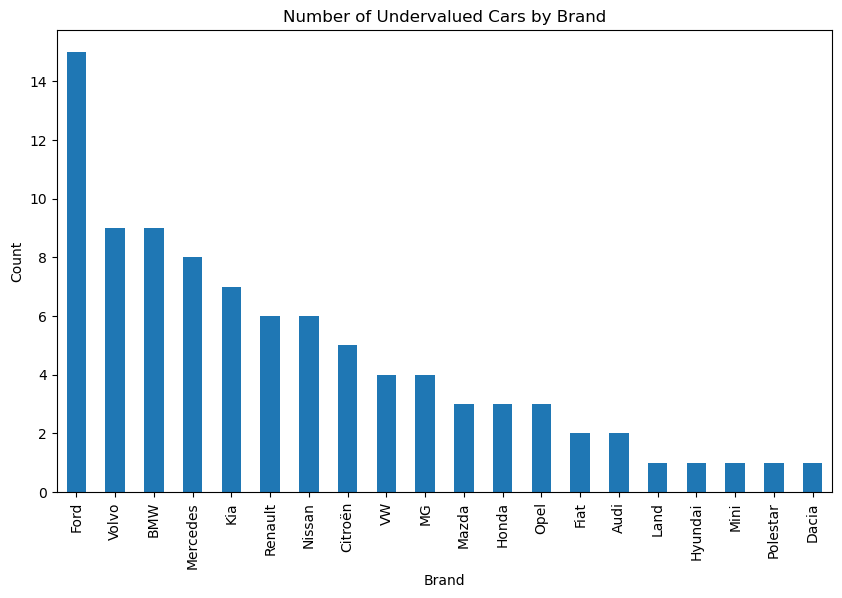

In [108]:
# Plot undervalued cars by brand
undervalued_with_details.groupby('Brand').size().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Number of Undervalued Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()